# LSTM Network

In [ ]:
import os, sys
import datetime

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Flatten

# TF optimizations for laptop
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Hide all GPUs from TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Reduce verbose logging
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '1'  # Enable OneDNN optimizations
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Reduce verbose logging
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '1'  # Enable OneDNN optimizations
tf.config.threading.set_intra_op_parallelism_threads(4)
tf.config.threading.set_inter_op_parallelism_threads(2)# Verify CPU-only mode
print("Available devices:", tf.config.list_physical_devices())
print("GPU available:", tf.config.list_physical_devices('GPU'))

LOCAL = True
rootpath = os.path.dirname(os.path.dirname(os.getcwd()))
print(f"rootpath: {rootpath}")
# module_path = os.path.abspath(os.path.join(rootpath, 'src'))
# sys.path.insert(0, module_path)
sys.path.append(os.path.dirname(os.path.abspath('.')))
import data_challenge as data
import models_challenge as models

2025-07-17 12:25:22.791807: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752747922.820452 3824804 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752747922.828875 3824804 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752747922.851062 3824804 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752747922.851085 3824804 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752747922.851087 3824804 computation_placer.cc:177] computation placer alr

Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
GPU available: []
rootpath: /home/onur/WORK/DS/repos/TimeSeries/stocks_forecasting


2025-07-17 12:25:27.679332: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [2]:
if LOCAL:
    dirfpath = data.download_stock_price_prediction_challenge_data(rootpath)
    test_path = os.path.join(dirfpath, "test")
    train_stocks_path = os.path.join(dirfpath, "train", "stocks")
    train_indices_path = os.path.join(dirfpath, "train", "indices")
    
else:
    test_path = "/kaggle/input/stock-price-prediction-challenge/test"
    train_stocks_path = "/kaggle/input/stock-price-prediction-challenge/train/stocks"
    train_indices_path = "/kaggle/input/stock-price-prediction-challenge/train/indices",

paths = {
    'test_path': test_path,
    'train_stocks_path': train_stocks_path,
    'train_indices_path': train_indices_path}

Raw data already found in location /home/onur/WORK/DS/repos/TimeSeries/stocks_forecasting/data/stock-price-prediction-challenge.zip
Raw data already unzipped


## Model Training, Testing and Forecasting

In [3]:
target = 'Returns'
df = data.get_ticker_df('test_4', test_path, train_stocks_path)
df = data.add_indice_features(df, target, train_indices_path)
df = data.prepare_features(df, target=target, beta_window=10, ma_windows=[10, 20, 60], ewm_alpha=[0.1, 0.3, 0.5], lags=1, out_len=500)
train_df, test_df = data.split_df(df, train_ratio=0.8)
X_train, y_train = models.get_X_y_multistep(train_df, steps=11, target='Returns')
X_test, y_test = models.get_X_y_multistep(test_df, steps=11, target='Returns')

shape of final df: (500, 17)
Train shape: (400, 17), Test shape: (100, 17)
X shape: (390, 16), y_multi shape: (390, 11)
X shape: (90, 16), y_multi shape: (90, 11)


In [ ]:
def build_lstm_cnn(params):
    model = Sequential()
    model.add(Input(shape=(params['num_features'], 1)))
    model.add(Conv1D(32, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=32, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=64))
    model.add(Dense(units=params['num_outputs'])) 
    model.compile(optimizer='adam', loss=params['loss'])
    return model
def build_scalers(X_train, y_train):
    Xscaler = MinMaxScaler(feature_range=(0, 1))
    yscaler = MinMaxScaler(feature_range=(0, 1))
    X_train_scaled = Xscaler.fit_transform(X_train)
    X_test_scaled = Xscaler.transform(X_test)
    y_train_scaled = yscaler.fit_transform(y_train)
    y_test_scaled = yscaler.transform(y_test)
    return Xscaler, yscaler, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled

In [ ]:
params = {
    'num_features': X_train.shape[1],
    'num_outputs': y_train.shape[1],
    'loss': 'mean_squared_error'
}
model = build_lstm_cnn(params)
Xscaler, yscaler, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled = build_scalers(X_train, y_train)


In [ ]:
# 1) Define your early-stopping callback
earlystop_cb = EarlyStopping(
    monitor='val_loss',        # metric to watch
    min_delta=1e-4,            # minimum change to qualify as improvement
    patience=5,                # how many epochs with no improvement before stopping
    verbose=1,                 # prints a message when stopping
    restore_best_weights=True  # at end of training, rolls back to the best weights
)
reducelr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,      # reduce LR by this factor
    patience=3,      # after how many bad epochs
    verbose=1
)
history = model.fit(
    X_train_scaled,
    y_train_scaled,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_scaled, y_test_scaled),
    verbose=1,
    callbacks=[earlystop_cb, reducelr_cb] # , tensorboard_cb
    )

Epoch 1/100


13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 0.0497 - val_loss: 0.0091 - learning_rate: 0.0010
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0098 - val_loss: 0.0049 - learning_rate: 0.0010
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0070 - val_loss: 0.0035 - learning_rate: 0.0010
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0065 - val_loss: 0.0033 - learning_rate: 0.0010
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0061 - val_loss: 0.0034 - learning_rate: 0.0010
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0058 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0057 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0056 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 9/100
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0062
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.00050000

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Train RMSE: 0.03541
Test RMSE: 0.02765


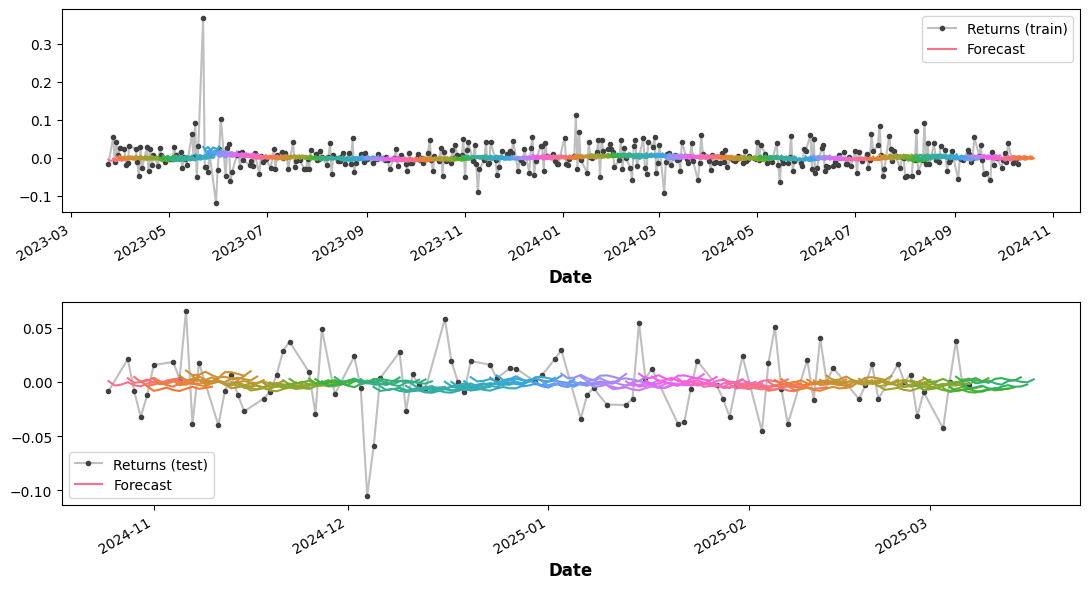

In [32]:
# train performance
y_hat_train = model.predict(X_train_scaled)
y_hat_train= yscaler.inverse_transform(y_hat_train)
y_hat_train = pd.DataFrame(y_hat_train, columns=y_train.columns, index=y_train.index)
# test prediction
y_hat_test = model.predict(X_test_scaled)
y_hat_test= yscaler.inverse_transform(y_hat_test)
y_hat_test = pd.DataFrame(y_hat_test, columns=y_test.columns, index=y_test.index)
models.evaluate_multistep(y_train, y_hat_train, y_test, y_hat_test, df, target)

In [ ]:
params = {}
tickers = ['test_1', 'test_2', 'test_3', 'test_4', 'test_5']
forecasts = models.run_forecasts(
    model_builder=build_lstm,
    params=params,
    model_type='NN',
    tickers=tickers,
    paths=paths
    )

In [ ]:
models.create_submission_file(forecasts, rootpath, tickers, fnamesuffix='_XGBRegChain')